In [ ]:
import tensorflow as tf

from numpy import asarray
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import cv2

from PIL import Image, ImageDraw, ImageFilter, ImageOps
from IPython import display
import csv

tf.__version__

'2.9.2'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
arr_64_L = np.load('/content/gdrive/My Drive/Projekteliai/Ahegao ROund2/64_L_numpy.npy')
# print the array
print(arr_64_L.shape)

arr_64_rgb = np.load('/content/gdrive/My Drive/Projekteliai/Ahegao ROund2/64_rgb_numpy.npy')
# print the array
print(arr_64_rgb.shape)

arr_32_L = np.load('/content/gdrive/My Drive/Projekteliai/Ahegao ROund2/32_L_numpy.npy')
# print the array
print(arr_32_L.shape)

arr_32_rgb = np.load('/content/gdrive/My Drive/Projekteliai/Ahegao ROund2/32_rgb_numpy.npy')
# print the array
print(arr_32_rgb.shape)

(3008, 64, 64)
(3008, 64, 64, 3)
(3008, 32, 32)
(3008, 32, 32, 3)


In [ ]:
arr_32_L = arr_32_L.reshape(arr_32_L.shape[0], 32, 32, 1).astype('float32')
arr_32_L = (arr_32_L - 127.5) / 127.5  # Normalize the images to [-1, 1]
#arr_32_L = arr_32_L/255
#arr_32_rgb = arr_32_rgb/255

In [ ]:
def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, 4, strides=2, padding='same',
                                     input_shape=[32, 32, 1]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


# def make_discriminator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Conv2D(32, 4, strides=2, padding='same',
#                                      input_shape=[32, 32, 1], activation='elu'))
#     model.add(layers.Conv2D(32, 4, strides=2, padding='same',
#                                      input_shape=[32, 32, 1], activation='elu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
#     model.add(layers.Dropout(0.2))


#     model.add(layers.Conv2D(64, 4, strides=2, padding='same', activation='elu'))
#     model.add(layers.Conv2D(64, 4, strides=2, padding='same', activation='elu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(128, 4, strides=2, padding='same', activation='elu'))
#     model.add(layers.Conv2D(128, 4, strides=2, padding='same', activation='elu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
#     model.add(layers.Dropout(0.4))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(1))

#     return model

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5, beta_2=0.999)

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 200 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    print("Gen loss: " + str(gen_loss)[10:19])
    print("Disc loss: " + str(disc_loss)[10:19])

    with open('G_loss.csv','a') as gf:
        gf.write(str(gen_loss)[10:15])
        gf.write("\n")

    with open('D_loss.csv','a') as gf:
        gf.write(str(disc_loss)[10:15])
        gf.write("\n")

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    images2=data_augmentation(images)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images2, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return  gen_loss, disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        #plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')

    if (epoch + 1) % 5 == 0:
        plt.savefig('temp/image_at_epoch_{:04d}.png'.format(epoch))

    plt.show()


In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

checkpoint_dir = '/content/gdrive/My Drive/Projekteliai/Ahegao ROund2/training normalisation -1_1 no rotation/training_ck_128'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        544       
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          32832     
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomRotation(0.05, input_shape=(32,32,1)),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomContrast(0.05),
    #layers.experimental.preprocessing.RandomWidth(0.1),
   # layers.experimental.preprocessing.RandomHeight(0.1),
  ]
)


In [ ]:
BUFFER_SIZE = 3000
BATCH_SIZE = 128

train_datas = tf.data.Dataset.from_tensor_slices(arr_32_L).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

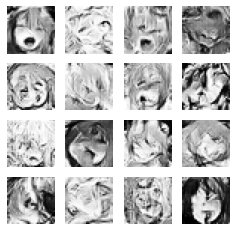

In [ ]:
train(train_datas, EPOCHS)
#nepamirsk creatint temp folderiuka savo base file'uose

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

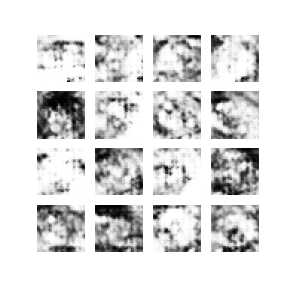

In [ ]:
display_image(945)

In [ ]:
anim_file = '2000, rotation 32rgb_01.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('temp/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

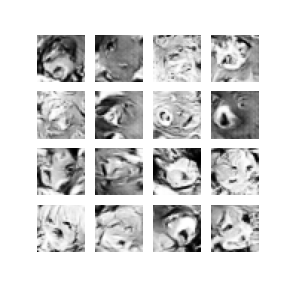

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('temp/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

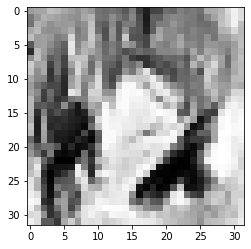

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

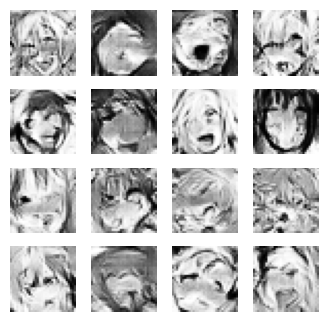

In [ ]:
 fig = plt.figure(figsize=(4, 4), dpi=100)

 for i in range(16):
        plt.subplot(4, 4, i+1)
        noise = tf.random.normal([1, 100])
        generated_image = generator(noise, training=False)
        plt.imshow(generated_image[0, :, :, 0], cmap='gray')
        plt.axis('off')

        with open('seed_number','a') as hf:
            hf.write(str(noise))
            hf.write("\n")
